**Semantic segmentation** challenges expose us to a lot of **metrics** and I mean **a lot**. 

So I have decided to make a list of as many as I can and try to explain and illustrate some of these (starting from 
simple ones and moving to more useful ones). 

Let's go!



<img src="https://neurohive.io/wp-content/uploads/2018/11/u-net-segmentation-e1542978983391.png">


**Note 1**: if you have a better suggestion for a banner image, please share it in the comments. :p

**Note 2**: the title is of course misleading, I won't discuss all the segmentation metrics, I might miss one or two. ;)

# Semantic segmentation targets

Before we can start, we have to define what we mean by semantic segmentation.

In **semantic segmentation** tasks, we predict a **mask**, i.e. where the **object of interest** is present.

Let's assume we only have one type of object to predict thus it is a **binary task**.

We can thus assign the following mapping: 
    
    
1. **0** for the **background** class.
2. **1** for the object of interest. 


For example, in the hubmap competition, **[glomuerli](https://en.wikipedia.org/wiki/Glomerulus_(kidney))** are the **1** class masks.

Now that we know what we are predicting, we can move to the metrics. 

Let's start with the easiest one: **accuracy**.

## Accuracy

This isn't the most clever one (will see why soon) but it is for sure the simplest so we should start with it.

How does it work?

We check all the image **pixels** and assign a score of **1** if the pixel is correctly predicted, **0** otherwise.

Thus, this can mathematically be represented by the [indicator function](https://en.wikipedia.org/wiki/Indicator_function) with the following formula: 



$Accuracy(A, B) = \frac{1}{n}\sum_{i=0}^{n}\mathbb{1}_{(A_{i} = B_{i})}$


i.e. if all the $A_{i}$'s and all the $B_{i}$'s are equal, the accuracy is equal to **1**. 


Next, to illustrate the accuracy metric and how it works (and doesn't in some cases), let's see an example. 

For that, I will generate an image with half background, half object of interest pixels. Here is the code in the next
cell: 

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import cv2

accuracy_mask = np.zeros((256, 256), dtype=np.uint8)
accuracy_mask[:256//2, :] = 1


plt.imshow(cv2.cvtColor(255 * accuracy_mask, cv2.COLOR_GRAY2RGB))


Thus, if we have a model that predicts everything as a background pixels (i.e. y = 0 for any input), we will get an accuracy of **0.5** or **50%**.

That's a good illustration of the accuracy metric.

What if we have less object pixels? 


In fact, that's what happens **99% of the time**: the backgournd is the vast majority of the image and the object
to predict represents only a tiny percentage of the whole (let's say between few percents to 10s of percents).


Let's take a more realistic example then and see what happens. 

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import cv2

unbalanced_mask = np.zeros((256, 256), dtype=np.uint8)
unbalanced_mask[0:10, 20:40] = 1
unbalanced_mask[100:120, 200:240] = 1


plt.imshow(cv2.cvtColor(255 * unbalanced_mask, cv2.COLOR_GRAY2RGB))

Here you can see that we have only few object pixels (in white). 
Around 10 * 20 + 20 * 20 = **600** pixels out of a total of 256 * 256 = **65536**.

That's **0.90%**, i.e. less than 1%.

If we now have the same model predict all background pixels, we will get an accuracy of

(65536 - 600) / 65536 = 0.9908 or 99.1%


That's a very high accuracy for a very bad model. How to explain this discrepancy?

Well, as in other machine learning tasks, the problem here comes from the fact that the dataset is highly 
**imbalanced**. Let's compute this imbalance: 



1. Background class 0: (65536 - 600) / 65536 = **0.9908**
2. Object class 1: 600 / 65536 = **0.0092**


What's a better metric for these types of unbalanced images?

Well, as for other **imbalanced datasets**, we can use similar concepts but slightly adapted for computer vision. Let's explore these. 

# Precision and Recall for Computer Vision

Without much surprise, we will use the two concepts of **precision** and **recall** slightly adapted to 
computer vision.

Before that, a quick reminder for those new to these two fundamental concepts. 

Even before that, let's start with the concept of **[confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)**.

## Confusion Matrix

To have a confusion matrix, we need some predictions and some ground truths. As said in the beginning,
we will only focus on binary perdictions for now but notice that the concept extends easily to multiclasses.

Let's generate a confusion matrix using [scikit-learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py): 

In [ ]:
from sklearn.metrics import confusion_matrix

# Imagine these are the first pixels of the masks: true vs predicted.
y_true = [0, 1, 1, 1, 0, 1, 1, 0]
y_pred = [0, 0, 0, 0, 1, 1, 1, 0]
confusion_m = confusion_matrix(y_true, y_pred)

import matplotlib.pyplot as plt
def plot_confusion_matrix(m, title='Confusion matrix'):
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    
    img = ax.matshow(m)
    plt.title(title)
    plt.colorbar(img)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["0", "1"], rotation=45)
    plt.yticks(tick_marks, ["0", "1"])
    plt.tight_layout()
    plt.ylabel("A")
    plt.xlabel("B")

plot_confusion_matrix(confusion_m)

We can see that we have 4 quadrants: 
    
    
- A: 0 vs B: 0
- A: 1 vs B: 0
- A: 0 vs B: 1
- A: 1 vs B: 1


If A are the true labels and B are the predicted labels and if 1 is the positive class (object of interest), then we get the following: 


- A: 0 vs B: 0 => **true negative** tha will be shortened to TN
- A: 1 vs B: 0 => **false negative** that will be shortened to FP
- A: 0 vs B: 1 => **false positive** that will be shortened to FN
- A: 1 vs B: 1 => **true positive**  that will be shortened to TP

We can place these labels in the confusion matrix.

Now that we have these 4 numbers (TP, FP, TN, FN) from the **confusion matrix**, we can build some useful metrics. 
Let's start with **precision**.

## Precision

As its name indicates, **precision** is **how precise the model is**, i.e. it is a measure of the quality 
of the predictions we make. 

To compute it, we need to have access to the true positives and the predicted positives (both true and false): 

$P := \frac{TP}{PP} = \frac{TP}{TP + FP}$

For example, if we make one single pixel prediction and it is correct, the precision is 1.
So one way to "game" this metric is to predict very few pixels from the object class, i.e. the less
predictions one makes, the less errors.



Let's go back to the second image with few object pixels and compute the precision of the model: 




In order to avoid the pitfalls of the precision, we will introduce another metric.

## Recall

Now the problem with predicting only one pixel from the object class even if it is correct is that
we are missing most of the object pixels, i.e. the recall is very low.

To compute it, we need to have access to the true positives and all the positive elements (both correct and uncorrectly predicted): 

$R := \frac{TP}{P} = \frac{TP}{TP + FN}$


If precision can be compared to the quality of the model, recall is then akin to quantity, i.e. how many of the true labels have been found. 


So, on the unbalanced image example, the more pixels we predict as the true class, the better will be the recall. 


As you can see, there is a balance to be found between **precision** and **recall**.

## $F_{1}$ score



<center> 
    <img src="https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg"> 
<center />
<center>
   Illustration from Wikipedia: https://en.wikipedia.org/wiki/F-score
<center/>

The $F_{1}$ score is a "harmonious" balance between precision and recall (you will soon learn why I have used such an adjective).

As we have seen in the previous two sections, using only **precision** or **recall** isn't enough.

One idea is to use both the metrics and combine their strengths. 

So the next immediate question that comes to mind is: how do we combine these two metrics?

One simple solution is to use the arithmetic mean. However, this mean suffers from extreme values.

For example, if the model has a precision of 1 and a recall of 0, the arithmetic mean will be 0.5.

Another better solution (will see why at the end), as outlined in this SO [thread](https://stackoverflow.com/questions/26355942/why-is-the-f-measure-a-harmonic-mean-and-not-an-arithmetic-mean-of-the-precision), is 
to use some measure theory.


Let's base our selection on the following six elements (which are the desired properties of a composite measure) adapted from the SO anwser: 


1. **Connectedness** (two pairs can be ordered) and **transitivity** (i.e. if e1 >= e2 and e2 >= e3 then e1 >= e3)

2. **Independence**: two components contribute their effects independently to the effectiveness.

3. Thomsen condition: given that at a constant recall (precision respectivaly), we find a difference in effectiveness for two values of precision (recall) 

then this difference cannot be removed or reversed by changing the constant value.

4. Restricted solvability.

5. Each component is essential: variation in one while leaving the other constant gives a variation in effectiveness.

6. Archimedean property for each component: tt merely ensures that the intervals on a component are comparable.


These desired properties give us an effectivness measure $E$ as follows:


$ E = 1 - \left(\frac{\alpha}{P} + \frac{1-\alpha}{R}\right)^{-1}$

where $\alpha$ is between 0 and 1, $P$ is the precision, and $R$ is the recall.

In turn, this effectivness measure is linked to the $F_\beta$ score by: 

$F_\beta = 1  - E$

where $\alpha = \frac{1}{1 + \beta^2}$

Taking $\beta = 1$, we get the F1 score. This gives: $\alpha = \frac{1}{1 + 1} = \frac{1}{2}$



$F_{1} = \left(\frac{0.5}{P} + \frac{0.5}{R}\right)^{-1}$

This is the formula of the [harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean) (which is said to be the "correct" average
when having ratios, which is the case for precision and recall) of $P$ and $R$.

Back to the first example of precision 1 and recall of 0: this time, the harmonic mean is 0. Much better!


Let's see why this formula works?

For that, we need to compute the derivative of the effectivness with regards to $P$ and $R$. 
Let's denote by $D$ the denomniator.

Then: 

$\frac{\partial E}{\partial P} = -\frac{\alpha}{P^{2}D^{2}}$

and

$\frac{\partial E}{\partial R} = -\frac{(1-\alpha)}{R^{2}D^{2}}$

Thus, to have a good effectivness, both derivatives should be equal. This happens exactly when:

$\frac{R}{P} = \sqrt{\frac{1-\alpha}{\alpha}}$




or in other words, using the forumla for $\beta$, when $R = \beta P$.



More technical details can be found [here](https://www.cs.odu.edu/%7Emukka/cs795sum09dm/Lecturenotes/Day3/F-measure-YS-26Oct07.pdf#page=3) and [here](http://openlib.org/home/krichel/courses/lis618/readings/rijsbergen79_infor_retriev.pdf#page=135).  


As a final thing about the $F_{1}$ score, let's see how the formula becomes when 
using $TP$, $FP$, and $FN$ (these come from the definition of R and P of course):

$F_{1} := \left(\frac{0.5}{P} + \frac{0.5}{R}\right)^{-1} = \frac{2PR}{R + P}$

$F_{1} = \frac{2\frac{TP}{TP + FP}\frac{TP}{TP + FN}}{\frac{TP}{TP + FP} + \frac{TP}{TP + FN}}$

After simplifications (one can factor a $TP$ from both numerator and denominator for example), we get: 

$F_{1} = \frac{2 TP}{2 TP + FP + FN}$


In the formula, we can see one limitation of the **$F_{1}$ score**: true negatives aren't used directly. One often
cited alternative to the $F_{1}$ score is the [Mathhews correlation coefficient](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient). This metric takes into account the true negatives.


For more details, check this great [blog post](https://deepai.org/machine-learning-glossary-and-terms/f-score) introducing the notion of **$F_{1}$ score**.

Now that the **$F_{1}$ score** has been explained, we can move again to **segmentation metrics**.

# From F1 score to Dice score

[Dice score](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient), also known as Dice-Sørensen coefficient (it has many more names), is another name for the **F1 score** that you will find a lot more on the context of computer vision.


Here is how it is defined when applied to two sets of pixels $A$ and $B$, where $A$ is the 
set of true pixels and $B$ the set of predicted ones:



$DSC(A, B) :=  \frac{2 |A \cap B|}{|A| + |B|}$



Let's see how it is equal to the **F1 score** by computing it (we will use the simplifed version from above): 



$F_{1}(A, B) =  \frac{2 TP(A, B) }{2 TP(A, B) + FP(A, B) + FN(A, B)}$


As you can see, these are the same by noticing that: 

$TP(A, B) = |A \cap B|$

that:

$TP(A, B) + FP(A, B) =  |B|$

and that:

$FN(A, B) + TP (A, B) = |A|$


Alright, now that we have established the link between Dice and F1, let's move to other often encountered metrics: **Jaccard** and **IoU**.

# What about Jaccard and IoU?

These are other metrics that come often in the context of **Dice** score and are closely related as we will see below.

So what are the differences?


Let's start by defining the **Jaccard metric** to see how it links to the **Dice** one:



$J(A,B) := {{|A \cap B|}\over{|A \cup B|}} = {{|A \cap B|}\over{|A| + |B| - |A \cap B|}}$

where **A** and **B** are the mask pixels: for example **A** is the ground truth ad **B** is the predicted mask.

Here is an illustration: 


<center > <img src="https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_stop_sign.jpg"> <center />

<center > From: https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/ <center/>

    

Jaccard metric, also known as the [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index) is another name for IoU metric, i.e. intersection over union which is definitely more explicit.


Now that these are defined, what is the link with the **Dice** metric?


As a reminder, here is how the Dice metric is defined: 


$DSC(A, B) =  \frac{2 |A \cap B|}{|A| + |B|}$


From the two formula (Jaccard vs Dice), we can establish that (the trick is to get $\frac{|A| + |B|}{|A \cap B|}$ from the Jaccard coefficient): 
    
    
$J(A,B)^{-1} + 1 = 2DSC(A, B)^{-1}$

then 
    
$DSC(A, B) = \frac{2 J(A, B)}{1 + J(A, B)}$
    

Notice that if $J$ is close to 0, $D$ is around twice $J$ (we will check this emperically on the next section).
    
Since one moves from one metric to another using an increasing metric, we can use one or the other.
 
For more details, check the following StackExchange [thread](https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou).

Enough with theory, time for some application and what better than using the current competition's dataset.

# Application: one simple model and metrics. 

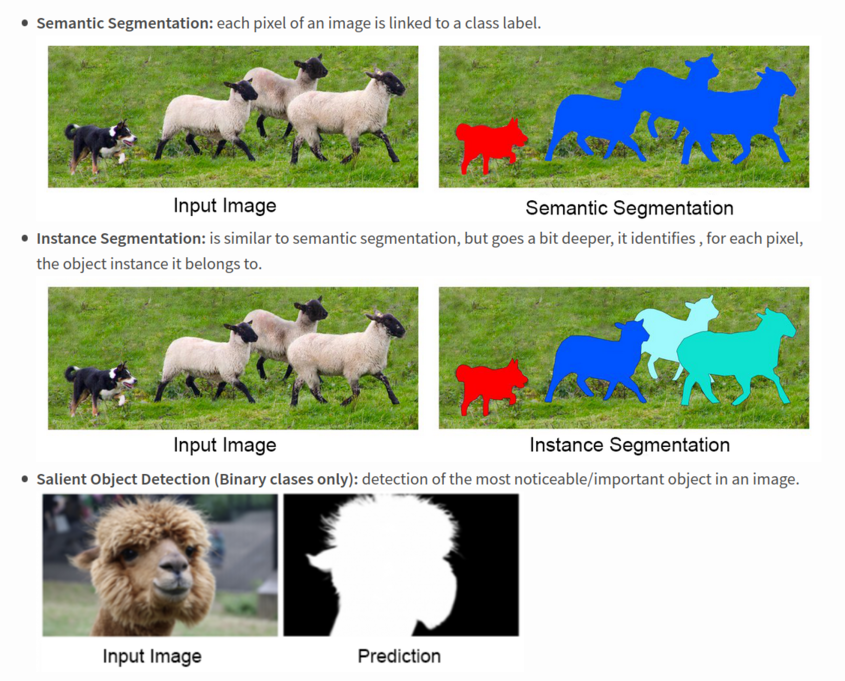

<center>  Source: https://pypi.org/project/SemTorch/ <center/>

Alright, time to apply some of the new things we have explored.

For that, we will be using the fastai framework and train for few epochs and for only one fold. 

Let's start by setting a simple semantic segmentation mdoel using [fastai](https://www.fast.ai/). To be more precise, I will be using **[SemTorch](https://github.com/WaterKnight1998/SemTorch)** (more suitable for segmentation). 

For the curious, here is a more complete [notebook](https://github.com/WaterKnight1998/Deep-Tumour-Spheroid/blob/develop/notebooks/UNet.ipynb) using the SemTorch library.

Notice also that some of the code is inspired from this [original](https://www.kaggle.com/iafoss/hubmap-pytorch-fast-ai-starter?scriptVersionId=0) work by [lafoss](https://www.kaggle.com/iafoss).  

Also, the dataset is a resized one (to 256 x 256).


Finally, before we start, notice that the model here is just an illustration of the segmentation metrics and you should spend more time to improve it so don't be suprised to see low scores. If you seen any bug, please let me know in the comments. :)


Let's start by installing the missing libraries.

In [ ]:
# SemTorch and pytorch_toolbelt (for metrics)

!pip install  -q SemTorch
!pip install -q pytorch_toolbelt 

In [ ]:
# Some useful imports.

from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *
from albumentations import *
# SemTorch
from semtorch import get_segmentation_learner
from torch.utils.data import Dataset
from pathlib import Path
import random
from sklearn.model_selection import KFold
import numpy as np
import cv2


%matplotlib inline

In [ ]:
# Some constants.

SEED = 314
BASE_FOLDER = Path("../input/hubmap-256x256")
MASKS_FOLDER = BASE_FOLDER / "masks"
IMG_FOLDER = BASE_FOLDER / "train"
LABELS_PATH = '../input/hubmap-kidney-segmentation/train.csv'
N_FOLDS = 5
NUM_WORKERS = 4
BATCH_SIZE = 4 # was 64 but too much for Kaggle.


In [ ]:
# Before we start, we need to seed!

random.seed(SEED)
set_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
train_img_mean = np.array([0.65459856,0.48386562,0.69428385])
train_img_std = np.array([0.15167958,0.23584107,0.13146145])


def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


#https://www.kaggle.com/bguberfain/memory-aware-rle-encoding
def rle_encode_less_memory(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    This simplified method requires first and last pixel to be zero
    '''
    pixels = img.T.flatten()
    
    # This simplified method requires first and last pixel to be zero
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)


def img2tensor(img, dtype: np.dtype=np.float32):
    if img.ndim==2 : 
        img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))

class HuBMAPDataset(Dataset):
    def __init__(self, fold=0, train=True, tfms=None):
        ids = pd.read_csv(LABELS_PATH).id.values
        kf = KFold(n_splits=N_FOLDS, random_state=SEED,shuffle=True)
        ids = set(ids[list(kf.split(ids))[fold][0 if train else 1]])
        self.fnames = [fname for fname in os.listdir(IMG_FOLDER) if fname.split('_')[0] in ids]
        self.train = train
        self.tfms = tfms
        
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        img = cv2.cvtColor(cv2.imread(os.path.join(IMG_FOLDER, fname)), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(MASKS_FOLDER, fname),cv2.IMREAD_GRAYSCALE)
        if self.tfms is not None:
            augmented = self.tfms(image=img, mask=mask)
            img,mask = augmented['image'],augmented['mask']
        return img2tensor((img/255.0 - train_img_mean)/train_img_std),img2tensor(mask)
    
def get_aug(p=1.0):
    return Compose([
        HorizontalFlip(),
        VerticalFlip(),
        RandomRotate90(),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
        OneOf([
            HueSaturationValue(10,15,10),
            CLAHE(clip_limit=2),
            RandomBrightnessContrast(),            
        ], p=0.3),
    ], p=p)



To check that our dataset pipeline is working, let's plot some of the images and masks as an overaly.

In [ ]:
ds = HuBMAPDataset(tfms=get_aug())
dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
imgs, masks = next(iter(dl))

plt.figure(figsize=(12, 12))
for i,(img,mask) in enumerate(zip(imgs,masks)):
    img = ((img.permute(1,2,0)*train_img_std + train_img_mean)*255.0).numpy().astype(np.uint8)
    plt.subplot(2, 2, i+1)
    plt.imshow(img, vmin=0, vmax=255)
    plt.imshow(mask.squeeze().numpy(), alpha=0.2)
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)

As for the loss, we will use a symmetric version of [Lovasz](https://arxiv.org/pdf/1705.08790.pdf) (more on this loss in the final section): 

In [ ]:
import pytorch_toolbelt.losses as L
lovasz = L.LovaszLoss()

def symmetric_lovasz(outputs, targets):
    return 0.5*(lovasz(outputs, targets) + lovasz(-outputs, 1.0 - targets))


As stated in the start of this section, we will only use one fold to make this notebook run faster and we will takee a batch size small enough so that the notebook's RAM is happpy. 

In [ ]:
ds_t = HuBMAPDataset(fold=0, train=True, tfms=get_aug())
ds_v = HuBMAPDataset(fold=0, train=False)
data = ImageDataLoaders.from_dsets(ds_t, ds_v,bs=BATCH_SIZE, num_workers=NUM_WORKERS, 
                                   pin_memory=True).cuda()

Time to get the segmentation pipeline. For that, `get_segmentation_learner` from SemTorch comes in handy.

In [ ]:
from semtorch import get_segmentation_learner

learn = get_segmentation_learner(dls=data, number_classes=2, 
                                 segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", 
                                 backbone_name="resnet50",
                                 loss_func=symmetric_lovasz,
                                 image_size=256,
                                 metrics=[Dice(), JaccardCoeff()], 
                                 wd=1e-2,
                                 pretrained=True,normalize=True).to_fp16()

We can now run the lr_find method to get a good starting learning rate.

In [ ]:
learn.lr_find() 
learn.recorder 

In [ ]:
monitor_training="valid_loss"
comp_training=np.less

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=2


fname="segmentation"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-5,1e-4), cbs=callbacksFitBeforeUnfreeze)

The model is learning but the loss is still quite high and the metrics aren't that good (maybe there is a bug?).

A second thing to notice is that the Dice metric is around twice the Jaccard metric. 
This is in concordance with what we have established therotically (the values are low so the approximation should hold) 
in the section above which is reassuring.



That's it with the main parts of this lengthy notebook. If you are curious, read the next sections with the following 
bonus sections:


1. instance segmentation 
2. multiclass segmentation
3. metrics libraries
4. metrics vs losses

# Bonus 1: instance segmentation

Instance segmentation is a variation of semantic segmentation where, instead of predicting "stuff", we predict "things". For example: cats, humans, etc.

This is a very "hand-wavy" way to introduce instance segmentation. A better definition could be found in the following paperswithcode [link](https://paperswithcode.com/task/instance-segmentation):

> Instance segmentation is the task of detecting and delineating each distinct object of interest appearing in an image.



Let's check how the instance segmentation metrics work and how they are linked (or not) to the semantic segmentation ones?

## mAP

<img src="https://www.jeremyjordan.me/content/images/2018/12/adjusted-PR-curve-1.png">

As you have guesseed it from the title above, a metric that is often used for instance segmentation is **mAP**, short for **mean average precision**. Let's explore how this metric works.


Before we start, notice that we will only explore the definition used at [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) (and more precisely for the latest version 2012). Other very close definition exist, for example there is one for the [COCO](https://cocodataset.org/#home) dataset.


First, we need to understand why there are two means: **mean** for the first **m** in the acronym and **average** for the **A** (in AP).


Let's start with the easiest bit: the mean **m**. It is taken over the different classes. In the 
binary case, there is no mean to take since we have only one class (the background doesn't count). 

Now, the more interesting part: the average precision. For that, we will use the graph above. 

For those familiar with machine learning, you might have recognized a similar graph: the [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) (short for receiver operating curve).

First things first, how do we get different metric values to plot a curve in the first place?

To start, we need to have a segmetnation score for each instance. 

For example, we can use IoU as the segmentation metric (as seen in the previous sections) and we get a value between 0 and 1 per class. From there, we need to get a binary score: is the instance correctly classified or not?

One possible way to do it is to use a threshold: if the IoU is > threshold, it is 1 (the object belongs to the class), otherwise it is 0.

For example, if we have an IoU of 0.89 for a cat class and we set the threshold to 0.9, then 
we will predict that the mask isn't a cat despite having a high IoU and this will be a false negative. If the threshold was 0.8, the prediction would have been a true positive. Having a small threshold means less false negatives but a threshold too low means more false positives so there is a balance as usual.


We then do this processing for all the different instances of the different images, for one class, and one threshold. 

Now, how do we compute precision and recall?

For that, we first need to rank all the predictions from largest IoU score to lowest (for a given threshold of course).

Let's suppose we have the following table of values for a threshold of 0.5 and an image containing 3 cats (it is a binary instance segmentation): 

| Item        | IoU |TP |
| ------------|-----|---|
| Cat 1       | 0.7 | 1 |
| Cat 2       | 0.6 | 1 |
| Cat 3       | 0.4 | 0 |

The TP column (true positive) is computed using the threshold. For example, the first row has an IoU of 0.7 > 0.5 so it is a true positive.

Since we have ranked the items from best to worst IoU, the precision and recall we will compute will be cumulative values as we go down the table. Let's add these two columns to our previous table: 

| Item        | IoU |TP | Precision|Recall      |
| ------------|-----|---|----------|------------|
| Cat 1       | 0.7 | 1 |1 / 1 = 1 |1 / 3 = 0.33|
| Cat 2       | 0.6 | 1 |2 / 2 = 1 |2 / 3 = 0.66|
| Cat 3       | 0.4 | 0 |2 / 3 = 0.66|2 / 3 = 0.66|


Let's go through each row to understand how precision and recall are computed:

- First row: we only have one prediction so far, so precision is 1. We have found one of the three cats so far, so recall of 0.33. 
- Second row: we have two predictions now and both are true positives, so a precision of 1. 
- Third row: we now have three predictions and only two are correct, so a precision of 0.66. The recall is still at 0.66.

One remarkable thing about this computation is that precision can go down when we move down the table but the recall will always increase (since the number of true positives can only increase).

This computation gives us the blue curve and we understand better how the "zigzags" can emerge.

Next, we interpolate the blue curve to get the orange one: instead of keeping dropping precision values, we use the maximum precision to the right of the current recall when a dip happens.

From there, we can compute average precision that is defiend as being the area under the orange curve. 

Notice that for previous versions of Pascal VOC, instead of directly computing the area, an 11 points sampling is done first.  

If we go back to the cats example, we get a score of 0.33.

That's it for mAP! 

The tricky part in this definition/computation, is that there are two levels of confusion matrix: one at the pixel level to first get the IoU score and then a second one at the instance level to get the curve.

One final thing to know is that for the COCO mAP, instead of using a single threshold of 0.5, it
uses instead different threshodls and takes an additional average over these.

# Bonus 2: multiclass segmentation

One other question to ask is: how to move from **binary semantic** segmentation to **multiclass segmentation**?

There are few things we need to change: 


- the metric computation of course.
- the dataset processing, especially the mask.
- the choice of the loss


As for the metric computation, let's assume it is IoU. A simple extension is to compute this 
metric for each class then take the mean of everything, this gives the mIoU. 
Often, it is better to exclude the background class from the mIoU computation.

As for the loss, if the different classes are balanced, we can use categorical cross  entropy.
If the classes are unbalanced, we can use the focal loss for example.


Finally, for the mask, we can encode each class as an integer from 0 to n-1 where n is the number of classes. For example, if we have 3 classes, let's say background, car, and pedestrian, we can have the following mapping: 

- 0 => background
- 1 => car
- 2 => pedestrian

The mask can look like this (we will reuse the same code from the first part but adapted): 



In [ ]:
import numpy as np
import matplotlib.pylab as plt
import cv2

accuracy_mask = np.zeros((256, 256), dtype=np.uint8)
accuracy_mask[50:100, :] = 1
accuracy_mask[:, 100: 150] = 2



plt.imshow(cv2.cvtColor(125 * accuracy_mask, cv2.COLOR_GRAY2RGB))

Nice. That's enough with multiclass segmentation, let's move to metrics libraries.

# Bonus 3: metrics libraries


In addition to the metrics we have shown in this notebook, there are of course many more. Instead of implementing everything from scratch, you can rely on existing libraries and avoid reinventing the wheel. 

Here are some of the metrics libraries that can be used:


- [pytorch](https://pytorch.org/): well, the easiest way is to implement it yourself from scratch.
- [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html) (of course)
- [pytorch-toolbelt](https://github.com/BloodAxe/pytorch-toolbelt): has many useful metrics including segmentation ones.
- [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/): a new library that has been extracted from Pytorch lightning.

# Bonus 4: metrics vs losses

There is one obvious way to define the loss from a metric that is:
    
`loss = 1 - metric`

Why does that work?

A metric is often better if it is higher and a loss is better the lower it is. Notice the use of 
often since some metrics are better when lower (for example MAE). If the metric is better when lower, you can define it as exactly the loss. 


However this approach has a big limitation: the metric isn't necessary differentiable so won't be suitable 
as a loss.


Thus, a loss needs to be differentiable (well at least in the [autograd](https://pytorch.org/docs/stable/autograd.html) sense of Pytorch).


To illustrate, here are some segmentation losses: 


- Jaccard loss: this is linked to the Jaccard metric via the trick above (or some variant). Here is an implementation (from [here](https://gist.github.com/wassname/17cbfe0b68148d129a3ddaa227696496)): 


``` python 
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/17cbfe0b68148d129a3ddaa227696496
    @author: wassname
    """
    intersection= (y_true * y_pred).abs().sum(dim=-1)
    sum_ = torch.sum(y_true.abs() + y_pred.abs(), dim=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth
```

- Binary cross entropy in the case of binary semantic segmentation when the classes are balanced (or categorical 
cross entropy for multiclasses).


- [Lovasz-softmax loss](https://arxiv.org/pdf/1705.08790.pdf)




<img src="https://paperswithcode.com/media/methods/Screen_Shot_2020-06-27_at_4.27.39_PM.png" width=480>




- [Focal loss](https://arxiv.org/pdf/1708.02002.pdf)
        
        
        
<img src="https://lh4.googleusercontent.com/_Zb8VyevBHbPdlPS1Bcph18b0GnRdY__yrSWaxEobHAOSq5izCVXdRS0Eo-26pU5Q8JE2daQAmFlwwUKnRiaf7JJrv7VJOLXbTOF-B6G8yshVWdBwhRXFBuMB5L6eH7KCTjzen-t7e39pxku5A" width=480>



The last two losses are useful when working with unblanced datasets which happens often with segmentation.



# Bonus 5: gIoU, dIoU, and cIoU.

IoU has some shortcomings when used as a loss. Indeed, it reaches a plateau and can't be optimized when used as a loss.

To fix these, we can use the genarlized IoU (shortened as gIoU), introduced in the following [paper](https://arxiv.org/pdf/1902.09630.pdf).

There are also dIoU (short for distance IoU) and cIoU (short for complete IoU).

# Before you go

That's if for this this very long notebook. 

I hope you have enjoyed reading about segmentation metrics and are now a bit less confused (at least I am after writing and searching for all these things).


See you around for another notebook!

In [ ]:
# TODO: Add a section about giou => https://giou.stanford.edu/ => in progress...
# gIoU paper: https://arxiv.org/pdf/1902.09630.pdf

# Other resources

Some additional links to go deeper if those above aren't enough: 

That's if for this this very long notebook. See you around for another notebook!

- https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch
- https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools
- more object and instance segmentation metrics explained in this blog (including mAP): https://medium.com/@yanfengliux/the-confusing-metrics-of-ap-and-map-for-object-detection-3113ba0386ef
- imbalanced datsets tutorial: https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28

Many mAP links (maybe I should make a separate notebook for this topic later :p): 
- https://stats.stackexchange.com/questions/462279/why-is-map-mean-average-precision-used-for-instance-segmentation-tasks
- https://www.jeremyjordan.me/evaluating-image-segmentation-models/
- https://towardsdatascience.com/map-mean-average-precision-might-confuse-you-5956f1bfa9e2
- https://kharshit.github.io/blog/2019/09/20/evaluation-metrics-for-object-detection-and-segmentation
- https://datascience.stackexchange.com/questions/25119/how-to-calculate-map-for-detection-task-for-the-pascal-voc-challenge
- https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173